# Capstone Project: Image classification to detect steps in making Chai(Indian Milk Tea)

**Overview**: In this project, we will use different Machine Learning algorithms on an Image Classification problem of identifying multiple steps in the preparation of Chai(Indian Milk Tea). We will use both Scikit learn and neural network models to measure accuracy of classificatio of different images. An optimized keras tensorflow model would be persisted as [model.tflit](./assets/model.tflite) to be used by the android app fo real time analysis of the pictures taken for the preparation.

The process of tea making broadly contains 5 steps
- Put the water in a pan
- Add tea leaves to water
- Wait for the water to boil and get the color of the tea leaves
- Pour Milk to boling water with tea leaves
- Wait for the tea to boil and start rising up the pan 


### Getting Started

The images for this project have been taken by myself over several days. These images were cleaned and converted to jpg format from iPhone proprietory format of .heic. Images can be accessed at [classes](./data/classes).


### Problem 1: Understanding the Data

Classified images have been put into 5 folders with 

- Folder **1** containin images of water in a pan.
- Folder **2** containin images of tea leaves in water.
- Folder **3** containin images of boiling water with tea leaves.
- Folder **4** containin images of Milk added to Step 3.
- Folder **5** containin images of Boiling tea.

<pre>
├── 1
│   ├── 1.jpg
│   ├── 10.jpg
│   ├── 125.jpg
│   ├── 132.jpg
...
├── 2
│   ├── 102.jpg
│   ├── 103.jpg
│   ├── 109.jpg
...

├── 3
│   ├── 100.jpg
│   ├── 101.jpg
│   ├── 104.jpg
...
├── 4
│   ├── 106.jpg
│   ├── 107.jpg
│   ├── 108.jpg
...
└── 5
    ├── 105.jpg
    ├── 121.jpg
    ├── 124.jpg
...
</pre>

### Problem 2: Read in the Data

We can read the data either directly through the file systesm or via a prepared [dataset](./tea_steps_250x250px.pkl) Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

Ensure a specifc version of threadpoolctl library is installed.

In [1]:
!pip install threadpoolctl==3.1.0

Import the required packages 

In [2]:
import joblib
import os
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from sklearn import datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


Configure the variables for the images size, label classes and the different paths. This assume that the project has been checked out at a relative path **code/final/kraftwerk/capstone_project** for a diff path change the variable **code_loc** below.

In [3]:
IMG_WIDTH = 250
IMG_HEIGHT = 250

class_names = ['1','2','3','4','5']
class_names_labels = ['Water', 'Tea Leaves', 'Boiling tea leaves', 'Tea with Milk', 'Boiling tea']

code_loc = 'code/final/kraftwerk/capstone_project'
data_path = fr'{os.getenv("HOME")}/{code_loc}/data/classes'
data_path_unknown = fr'{os.getenv("HOME")}/{code_loc}/data/unclassified'
tflite_model_path = fr'{os.getenv("HOME")}/{code_loc}/assets/model.tflite'
export_model_path = fr'{os.getenv("HOME")}/{code_loc}/model'
assets_path = fr'{os.getenv("HOME")}/{code_loc}/assets/'
export_json_file = os.path.join(assets_path, os.path.splitext(os.path.basename(export_model_path))[0] + ".json")
labelmap_file = fr'{os.getenv("HOME")}/{code_loc}/assets/labelmap.pbtxt'


Create a method to generate a dataset of resized images of provided width and height, attach a label to the image alongwith metadata of the filename a general description. We use [joblib.dump](https://joblib.readthedocs.io/en/stable/generated/joblib.dump.html) to dump the dictionary to be avoid having to resize the images frequently across multiple analysis.

In [4]:

def resize_save(src, pklname, width=250, height=250):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    height: int
        target height of the image in pixels.
    """
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb for different steps in the process of tea making'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        print('processing directory ' + str(subdir))
        current_path = os.path.join(src, subdir)
        for file in os.listdir(current_path):
            if file[-3:] in {'jpg', 'png'}:
                im = imread(os.path.join(current_path, file))
                im = resize(im, (width, height)) #[:,:,::-1]
                data['label'].append(subdir)
                data['filename'].append(file)
                data['data'].append(im)
 
    joblib.dump(data, pklname)

In [5]:
# Look at the classes of images existing in the data folder.
os.listdir(data_path)

['1', '4', '3', '2', '5']

The following code creates a file tea_steps_250x250.pkl that stores the serialized dictionary of resized images and the corresponding labels.

The generated file is already committed. If the images have to be regenerated, uncomment the code making sure that the new size has been updated above in the variables IMG_WIDTH and IMG_HEIGHT.

In [6]:
# Uncomment this to generate the dataset again

#base_name="tea_steps"
#resize_save(src=data_path, pklname=base_name)

Load the processed images from the file system. 

In [7]:
data = joblib.load(f'tea_steps_250x250px.pkl')
 
print('Total number of images in the sample: ', len(data['data']))
print('Description: ', data['description'])
print('Image shape: ', data['data'][0].shape)
print('Labels:', np.unique(data['label']))


Total number of images in the sample:  162
Description:  resized (250x250) images in rgb for different steps in the process of tea making
Image shape:  (250, 250, 3)
Labels: ['1' '2' '3' '4' '5']


There are 5 different classes of images. Let us take a look at one image from each of the classes.

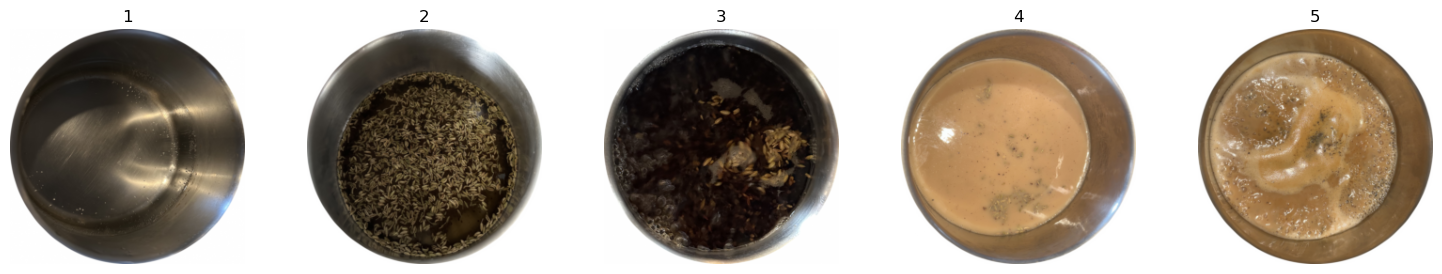

In [8]:
# Get all unique values in the list of labels
labels = np.unique(data['label'])
 
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label type. 
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

Define some methods that we will use to calculate accuracy of the different models.

In [9]:
# Store accuracy score on the train set
accuracy_scores_train =[]
# Store accuracy score of the test set
accuracy_scores_test =[]
# Store description of the model
model_descs = []
# Store to parameters of the best estimator
best_estimators = []

def append_model_accuracy_score(model_desc, accuracy_score_train, accuracy_score_test, best_estimator=''):
    '''
    update the datastructures with the passed values of the model and the associated scores for scikit models.
        Parameter
    ---------
    model_desc: str
        descripotion of the model
    accuracy_score_train: float
        accuracy score for the train set
    accuracy_score_test: float
        accuracy score for the test set
    best_estimator: float
        accuracy score for the test set
        
    '''  
    model_descs.append(model_desc)
    accuracy_scores_train.append(accuracy_score_train)
    accuracy_scores_test.append(accuracy_score_test)
    best_estimators.append(best_estimator)

In [10]:
def compute_accuracy(preds, ds):
    '''
        Parameter
    ---------
    preds: array of floats representing the s
        path to data
    ds: str
        path to output file
    '''
    train_label = []
    train_score = []
    for pred in preds:
        score = tf.nn.softmax(pred)
        train_label.append(class_names[np.argmax(score)])
    for images, labels in ds:
        for i in range(len(labels)):
            if class_names[labels[i]] == train_label[i]:
                train_score.append(True)
            else:
                train_score.append(False)
    
    return np.sum(train_score)/len(train_score)


def append_dl_model_accuracy_score(model, model_desc,train_ds, test_ds):
    '''
    update the datastructures with the passed values of the model and the associated scores for Deep learning models.
        Parameter
    ---------
    model:
        fitted model 
    model_desc: str
        descripotion of the model
    train_ds: Dataset
        dataset of images for training
    test_ds: Dataset
        dataset of images for test
        
    ''' 
    train_pred = model.predict(train_ds)
    train_score = compute_accuracy(train_pred, train_ds)
    test_pred = model.predict(test_ds)
    test_score = compute_accuracy(test_pred, test_ds)
    
    append_model_accuracy_score(model_desc, train_score, test_score)

Split the dataset into train and test.

In [11]:
 
X = np.array(data['data'])
y = np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

### Problem 2: Understanding how to convert image to features

Images can be stored in various formats, each with its own characteristics, compression methods, and use cases. Some common image formats are

- JPEG/JPG (Joint Photographic Experts Group)
- PNG (Portable Network Graphics)
- GIF (Graphics Interchange Format):
- BMP (Bitmap):
- TIFF (Tagged Image File Format):
- SVG (Scalable Vector Graphics):

The choice of image format depends on the specific requirements of the application, such as file size, image quality, transparency, and whether the image is a photograph or a graphic. 

For our usecase we have the images stored as JPG. Images can also have different color models. Common color models are

- RGB(Red Green Blue):- Thi is the most common colour model used in Digital image processing and openCV. The colour image consists of 3 channels. One channel each for one colour. Red, Green and Blue are the main colour components of this model.

- CMYK(Cyan, Magenta, Yellow and Black (key)):- It is a subtractive colour model. 0 represents the primary colour and 1 represents the lightest colour. In this model, point (1, 1, 1) represents black, and (0,0,0) represents white. It is a subtractive model thus the value is subtracted from 1 to vary from least intense to a most intense colour value.

- HSV(Hue, Saturation and Value):- This colour model does not use primary colours directly. It uses colour in the way humans perceive them. HSV colour when is represented by a cone.

- YIQ:- YIQ is the most widely colour model used in Television broadcasting. Y stands for luminance part and IQ stands for chrominance part. In the black and white television, only the luminance part (Y) was broadcast. The y value is similar to the grayscale part. The colour information is represented by the IQ part.

**We will use the RGB color model for analysis.**

#### Images to feature 

Image to feature conversion refers to the process of extracting meaningful features from an image in order to represent it in a more compact and informative way. 

Some common methods for image to feature conversion:

- Traditional Feature Extraction: This includes Color Histograms, Texture Analysis and Edge Detection.

- Deep Learning-based Feature Extraction: This includes Convolutional Neural Networks (CNNs) and Transfer Learning models like VGG16, ResNet, or Inception. CNNs are widely used for image feature extraction. They automatically learn hierarchical features from raw pixel values through convolutional layers.

- Key Point Detection and Description: This includes SIFT (Scale-Invariant Feature Transform) and SURF (Speeded-Up Robust Features).

- Autoencoders: This includes Variational Autoencoders (VAEs) and Denoising Autoencoders

- Bag-of-Visual-Words (BoVW): This includes Variational Autoencoders (VAEs) and Denoising Autoencoder

- Variational Autoencoders (VAEs) and Denoising Autoencoders: This includes Histogram of Oriented Gradients (HOG) and Local Binary Patterns (LBP)

- Spatial Pyramids: This includes Pyramid of Histograms of Oriented Gradients (PHOG)


**For the analysis we will use both Traditional Feature extraction and Deep Learning based Feature extraction techniques**
  


### Problem 3: Model training

We will start with Scikit learn models and then use Keras to train image classification models.

#### 3.1 scikit-learn Models

Before training the models we have to convert the RGB color model JPEG photos to feature vector. We will do multiple analysis first with converting images to gray scale. 
This converts a multidimensional color representation of the image int a single dimension gray scale representation. 

In [12]:
# Create an array of images converted to gray scale 
X_grey = []
for img2 in data['data']:
    img_gray = rgb2gray(img2)
    X_grey.append(img_gray)

Let us look at how an image looks like in gray scale.

Text(0.5, 1.0, 'Grey Scale')

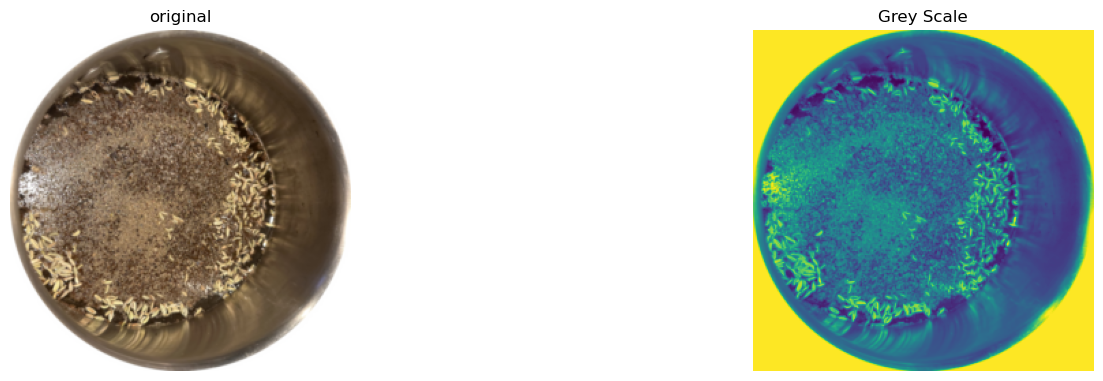

In [13]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,4)
fig.tight_layout()
# show the actual image on the left side
axes[0].imshow(data['data'][122])
axes[0].axis('off')
axes[0].set_title('original')

# show the Gray image
axes[1].imshow(X_grey[122])
axes[1].axis('off')
axes[1].set_title('Grey Scale')

The images have been cropped as a circle to focus only on the contents of the pan. This is causing the gray scale image to show yellow outer color in the gray scale image.

Create a feature vector per image for the image

In [14]:
X = []
for img2 in data['data']:
    img_gray = np.reshape(X_grey[len(data)],IMG_WIDTH*IMG_HEIGHT)
    X.append(img_gray)

# Split the data into train and test split.    
X = X
y = np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

Train a KNN classifier with default parameters.

In [15]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier()

Make predictions on the test set and visualize a few predictions. 

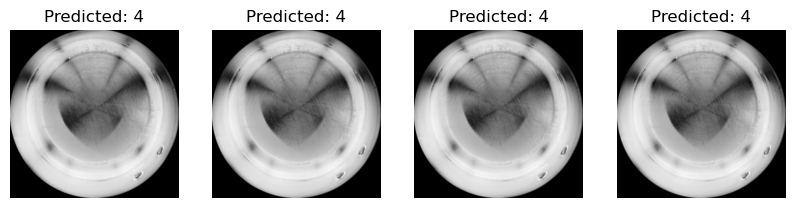

In [16]:
predicted = clf.predict(X_test)
_, axes = plt.subplots(nrows=1, ncols = 4, figsize=(10,3))
for ax, image, predictions in zip(axes, X_test, predicted):
  ax.set_axis_off()
  image= image.reshape(IMG_WIDTH,IMG_HEIGHT)
  ax.imshow(image, cmap = plt.cm.gray_r)
  ax.set_title("Predicted: %s" %predictions)

From the above, it seems like the same class predictions have been made on the entire dataset. Let us also verify this by visualizing the confusion matrix.

[False False False False False  True False False False False  True False
 False False  True  True False False False False False  True False False
  True False False False False False False False False]

Percentage correct:  18.181818181818183


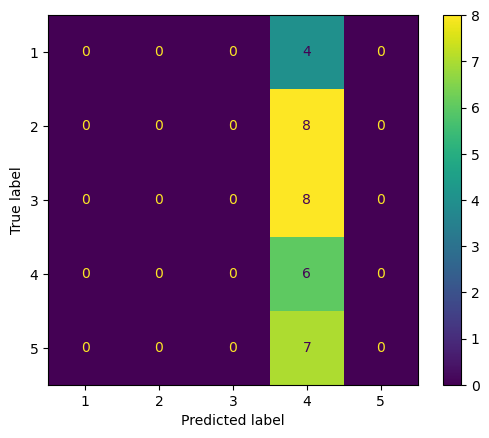

In [17]:
print(np.array(predicted == y_test))
print('')
print('Percentage correct: ', 100*np.sum(predicted == y_test)/len(y_test))
predict_train = clf.predict(X_train)
append_model_accuracy_score('KNeighborsClassifier', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

Let us perform a grid search for KNeighborsClassifier to explore if the model accuracy improves. We will also standardise the pixel values 

In [18]:
params = {'model__n_neighbors':range(5, 50, 5),
          'model__weights':['uniform', 'distance'],
         }
knn_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('model',KNeighborsClassifier()),
])
knn_grid = GridSearchCV(knn_pipe,  param_grid = params)
knn_grid.fit(X_train, y_train)
knn_grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=45))])

Let us look at the predictions on the test data 

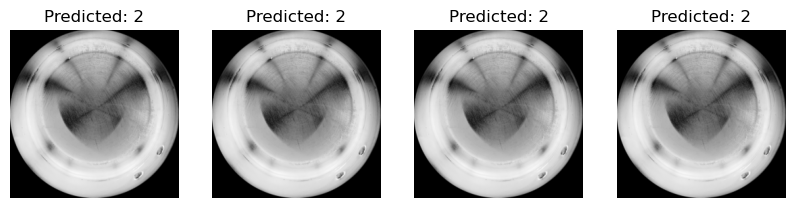

In [19]:
predicted = knn_grid.predict(X_test)
_, axes = plt.subplots(nrows=1, ncols = 4, figsize=(10,3))
for ax, image, predictions in zip(axes, X_test, predicted):
  ax.set_axis_off()
  image= image.reshape(IMG_WIDTH,IMG_HEIGHT)
  ax.imshow(image, cmap = plt.cm.gray_r)
  ax.set_title("Predicted: %s" %predictions)

It seems like all the predictions have been 2. Another observstion is that the grey scale images seems to look a lot similar. Let us look at the confusion metrics. 

[False  True False False  True False  True False  True False False False
 False False False False False  True  True False False False False False
 False False  True False False  True False False False]

Percentage correct:  24.242424242424242


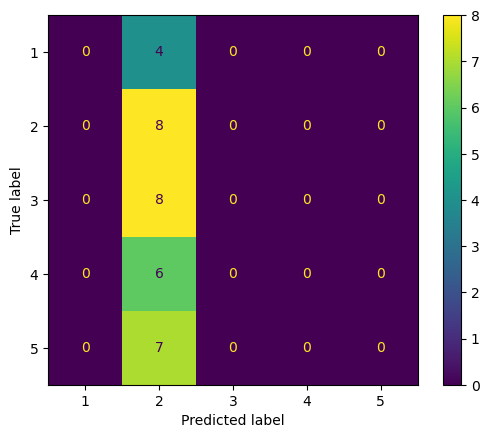

In [20]:
predicted = knn_grid.predict(X_test)
print(np.array(predicted == y_test))
print('')
print('Percentage correct: ', 100*np.sum(predicted == y_test)/len(y_test))
predict_train = knn_grid.predict(X_train)

append_model_accuracy_score('KNeighborsClassifier GridSearch', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test),knn_grid.best_estimator_)

metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

The above analysis shows that using KNN the prediction accuracy remained really low. Let us explore an SVN model with Grid search still using Gray scale images.

In [21]:
params = {'model__kernel': ['linear','poly','rbf','sigmoid'],
         'model__degree': range(3, 10),
         'model__gamma':['scale', 'auto']}
svc_pipe = Pipeline([('scaler',StandardScaler()),
                      ('model', SVC())])
grid_cv_scv = GridSearchCV(estimator=svc_pipe,param_grid=params,cv=5)
grid_cv_scv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC())]),
             param_grid={'model__degree': range(3, 10),
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

Let us make predictions on the test data and visualize a few pairs of predictions and the predicted value.

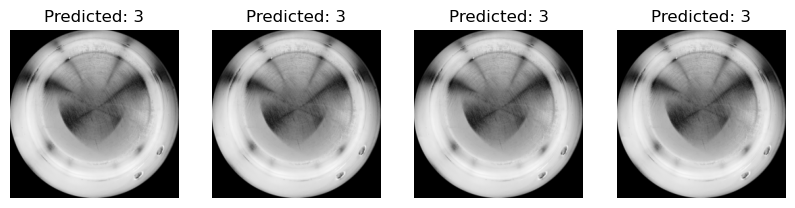

In [22]:
predicted = grid_cv_scv.predict(X_test)
_, axes = plt.subplots(nrows=1, ncols = 4, figsize=(10,3))
for ax, image, predictions in zip(axes, X_test, predicted):
  ax.set_axis_off()
  image= image.reshape(IMG_WIDTH,IMG_HEIGHT)
  ax.imshow(image, cmap = plt.cm.gray_r)
  ax.set_title("Predicted: %s" %predictions)

[False False False  True False False False  True False False False  True
 False  True False False False False False False  True False False False
 False False False  True False False False  True  True]

Percentage correct:  24.242424242424242


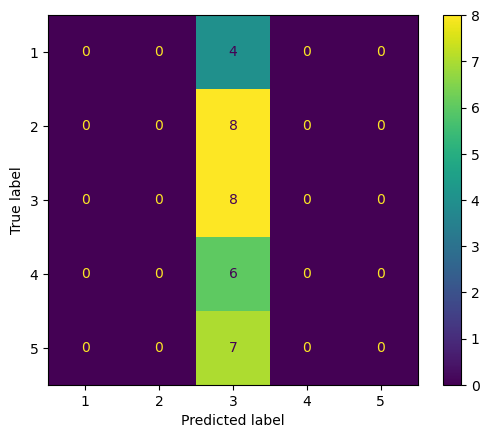

In [23]:
predicted = grid_cv_scv.predict(X_test)
print(np.array(predicted == y_test))
print('')
print('Percentage correct: ', 100*np.sum(predicted == y_test)/len(y_test))
predict_train = grid_cv_scv.predict(X_train)

append_model_accuracy_score('SVC GridSearch(Gray Scale) ', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test),grid_cv_scv.best_estimator_)

metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

Let us print the model accuracy of the different models

In [24]:
results = {'model':model_descs,'train score':accuracy_scores_train,'test score':accuracy_scores_test}
results_df = pd.DataFrame(results)
#results_df = results_df.set_index('model')

results_df.sort_values(by='test score', ascending=False)

,model,train score,test score
1,KNeighborsClassifier GridSearch,0.255814,0.242424
2,SVC GridSearch(Gray Scale),0.271318,0.242424
0,KNeighborsClassifier,0.178295,0.181818


We see that the model accuracy continues to stay really low. This is due to the fact that all of the images have the same shape but there is color difference. Hence grey scale analysis is causing the model performance to stay consistently low. 



**HOG Analysis on gray scale images**

The Histogram of Oriented Gradients (HOG) is a feature descriptor widely used in computer vision and image processing for object detection. HOG focuses on the distribution of gradient orientations in an image.

Here's a breakdown of the key concepts:

- Gradient Computation: The first step involves computing the image gradients. Gradients represent the change in intensity or color across the image. Typically, the Sobel operator is used to compute the gradient in both the horizontal and vertical directions.

- Cell Division: The image is divided into small, non-overlapping cells. The gradient information within each cell is then used to compute histograms.

- Histogram Calculation: Within each cell, a histogram of gradient orientations is created. This histogram represents the distribution of gradient directions within that cell. The orientations are usually quantized into discrete bins (e.g., 9 bins covering 0 to 180 degrees).

- Block Normalization: The cells are grouped into larger blocks. Normalization is applied to the histograms within each block. This normalization helps in dealing with changes in lighting and contrast.

- Descriptor Formation: The final feature descriptor is formed by concatenating the normalized histograms from all the cells within all the blocks. This results in a feature vector that captures the distribution of gradient orientations in the entire image.

The HOG descriptor is particularly useful for object detection because it captures the local object shape and edge information while being somewhat robust to changes in illumination and contrast. The use of histograms of gradient orientations provides a representation that is less sensitive to absolute intensity values.

HOG has been widely used in combination with machine learning techniques, such as support vector machines (SVMs), for tasks like pedestrian detection in images. It's an effective method for representing object features in a way that is invariant to certain variations in the input data.


This article from [opencv](https://learnopencv.com/histogram-of-oriented-gradients/) shows the above steps in a lot more detail. We will still convert to gray scale image and then use [skimage.feature.hog](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html) to create a feature vector. 

Let us create a Transformer to wrap the different parameters required by the hog function

In [25]:
# import required modules 
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

class RGB2FeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale and extract hog from the resulting image
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(2, 2),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return_arr = []
        for img in X:
            # Convert image to gray scale
            img2 =  skimage.color.rgb2gray(img)
            # Call the hog function
            image_feature = hog(img2,orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
            return_arr.append(image_feature)
        return np.array(return_arr)


In [26]:
# Import modules specific for model training
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage 

# reinitialize X and Y with raw dataset and split them into train and test data
X = np.array(data['data'])
y = np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

Create a pipeline using RGB2FeatureTransformer and some default values for the other parameters  

In [27]:
svc_pipe = Pipeline([
    ('xform',RGB2FeatureTransformer(
    pixels_per_cell=(5, 5), 
    cells_per_block=(3,3), 
    orientations=9, 
    block_norm='L2-Hys')),
    ('scalar',StandardScaler()),
    ('clf',SVC(random_state=42, max_iter=1000, tol=1e-3))
])
svc_pipe.fit(X_train,y_train)

Pipeline(steps=[('xform', RGB2FeatureTransformer(pixels_per_cell=(5, 5))),
                ('scalar', StandardScaler()),
                ('clf', SVC(max_iter=1000, random_state=42))])

Let us make the predictions using this model and measure the accuracy

[False  True  True  True  True  True False  True  True False False  True
  True  True False False False  True False False  True False False False
 False False False  True  True  True False  True  True]

Percentage correct:  51.515151515151516


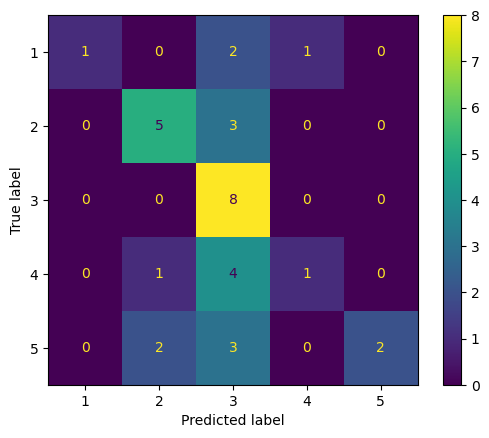

In [28]:
y_pred = svc_pipe.predict(X_test)
print(np.array(y_pred == y_test))
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
predict_train = svc_pipe.predict(X_train)

append_model_accuracy_score('SVC with Hog', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test))

metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

So we see that this model does have a higher model accuracy then the other models so far. Let us do a GridSearch over the different parameters to find the best estimator.

In [29]:
params = {'xform__pixels_per_cell':[(6, 6),(7,7),(8, 8),(9, 9)],
         'xform__cells_per_block':[(2, 2),(3, 3),(4, 4),(5,5)],
          'model__degree': range(3, 10),
         }

svm_pipe = Pipeline([
    ('xform',RGB2FeatureTransformer()),
    ('scalar',StandardScaler()),
    ('model', SVC())
])
svm_grid = GridSearchCV(estimator = svm_pipe, param_grid = params)
svm_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('xform', RGB2FeatureTransformer()),
                                       ('scalar', StandardScaler()),
                                       ('model', SVC())]),
             param_grid={'model__degree': range(3, 10),
                         'xform__cells_per_block': [(2, 2), (3, 3), (4, 4),
                                                    (5, 5)],
                         'xform__pixels_per_cell': [(6, 6), (7, 7), (8, 8),
                                                    (9, 9)]})

Let us makes predictions using the best estimator and look at the model accuracy.

[False  True  True  True  True  True  True  True  True  True False  True
  True  True False False  True  True False False  True  True False  True
  True False False  True  True  True  True  True  True]

Percentage correct:  72.72727272727273


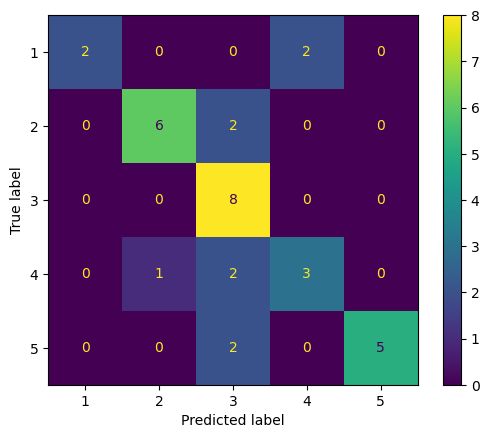

In [30]:
predicted = svm_grid.predict(X_test)
print(np.array(predicted == y_test))
print('')
print('Percentage correct: ', 100*np.sum(predicted == y_test)/len(y_test))
predict_train = svm_grid.predict(X_train)

append_model_accuracy_score('SVC GridSearch(with Hog)', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test),svm_grid.best_estimator_)

metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

Before moving on with Deep Learning models, let us compare the accuracy of scikit learn models.

In [31]:
results = {'model':model_descs,'train score':accuracy_scores_train,'test score':accuracy_scores_test}
results_df = pd.DataFrame(results)
#results_df = results_df.set_index('model')

results_df.sort_values(by='test score', ascending=False)

,model,train score,test score
4,SVC GridSearch(with Hog),1.000000,0.727273
1,KNeighborsClassifier GridSearch,0.255814,0.242424
2,SVC GridSearch(Gray Scale),0.271318,0.242424
3,SVC with Hog,1.000000,0.242424
0,KNeighborsClassifier,0.178295,0.181818


From the above we can see that SVC using Hog was able to achieve an accuracy of 72.7% on test data the highest among this category of models.  

#### 3.2 Deep Learning Models

Before starting with the model training let us understand a few terms

- Deep learning:-  is a subfield of machine learning that focuses on artificial neural networks and deep neural networks, which are inspired by the structure and function of the human brain. The term "deep" in deep learning refers to the use of deep neural networks with multiple layers (deep architectures) to model and solve complex problems. These networks are capable of learning hierarchical representations of data, where each layer captures different levels of abstraction or features.

- TensorFlow:- is an open-source machine learning framework developed by the Google Brain team. It provides a comprehensive set of tools, libraries, and community resources for building and deploying machine learning models. TensorFlow is designed to facilitate the development and training of machine learning models, particularly deep neural networks, for a wide range of applications.

- Keras:- is an open-source high-level neural networks API written in Python. It acts as an interface for building and training deep learning models. Keras is designed to be user-friendly, modular, and extensible. It allows developers to define and configure complex neural network models using a high-level, intuitive syntax.

**We will be using Keras as a High-Level API for TensorFlow.**

In [32]:
# install tensorflow dependencies
!pip install tensorflow-macos==2.15.0


In [33]:
# Import different modules required for training Tensorflow model.
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Define the directory to load all the categorized images from the disk with a batch size of 200.

In [34]:
import pathlib
data_dir = pathlib.Path(data_path).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
# define paramters for the loader
batch_size = 200

162


Load the train and test datasets from the disk with a split of 20% specifying the image size for resizing the loaded images.

In [35]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=batch_size)

Found 162 files belonging to 5 classes.
Using 130 files for training.


2023-12-11 22:53:03.922715: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-11 22:53:03.922740: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-11 22:53:03.922746: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-11 22:53:03.923012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-11 22:53:03.923401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=batch_size)

Found 162 files belonging to 5 classes.
Using 32 files for validation.


Plot the first 6 pictures from the train dataset

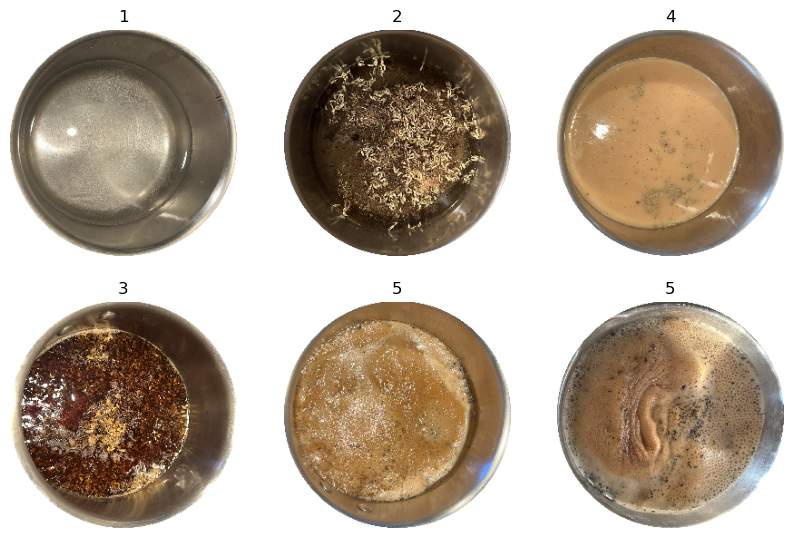

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In order to optimize the model execution time, we can use [prefetching](https://www.tensorflow.org/guide/data_performance#prefetching). Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data. We set this value to **tf.data.AUTOTUNE**, which will prompt the tf.data runtime to tune the value dynamically at runtime.

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)




Let us create a basic model with 

- The Rescaling layer is used to scale the pixel values of the input images to the range [0, 1].

- Three convolutional layers (Conv2D) with increasing numbers of filters (16, 32, 64), 3x3 kernel size, 'same' padding, and Rectified Linear Unit (ReLU) activation.

- Max pooling layers (MaxPooling2D) after each convolutional layer to downsample the spatial dimensions.

- A Flatten layer to flatten the output of the last convolutional layer into a 1D array.

- A fully connected (Dense) hidden layer with 128 neurons and ReLU activation.

The output layer (Dense) with num_classes neurons. The final layer has no activation function as this is a multi-class classification.

In [39]:
num_classes = len(class_names)

# Define the model
basic_model = Sequential([
    # Rescale pixel values to the range [0, 1]
    layers.Rescaling(1./255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    
    # First convolutional layer with 16 filters, 3x3 kernel, 'same' padding, and ReLU activation
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    
    # Max pooling layer
    layers.MaxPooling2D(),
    
    # Second convolutional layer with 32 filters, 3x3 kernel, 'same' padding, and ReLU activation
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    
    # Another max pooling layer
    layers.MaxPooling2D(),
    
    # Third convolutional layer with 64 filters, 3x3 kernel, 'same' padding, and ReLU activation
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    
    # Another max pooling layer
    layers.MaxPooling2D(),
    
    # Flatten the output to a 1D array
    layers.Flatten(),
    
    # Fully connected layer with 128 neurons and ReLU activation
    layers.Dense(128, activation='relu'),
    
    # Output layer with 'num_classes' neurons (for classification task)
    layers.Dense(num_classes)
])


Compile the model specifying a loss function that computes the crossentropy loss between the labels and prediction. We will use the accuracy metric. 

In [40]:
basic_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
# Look at the model summary to verify it has 3 layers, the input and the output.
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1

In [42]:
# Number of iterations through the training set.
epochs=100
# Fit the model, specifying the verbosity to 0.
history = basic_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  verbose=0     
)

2023-12-11 22:53:05.853903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Let us create plots of the loss and accuracy on the training and validation sets

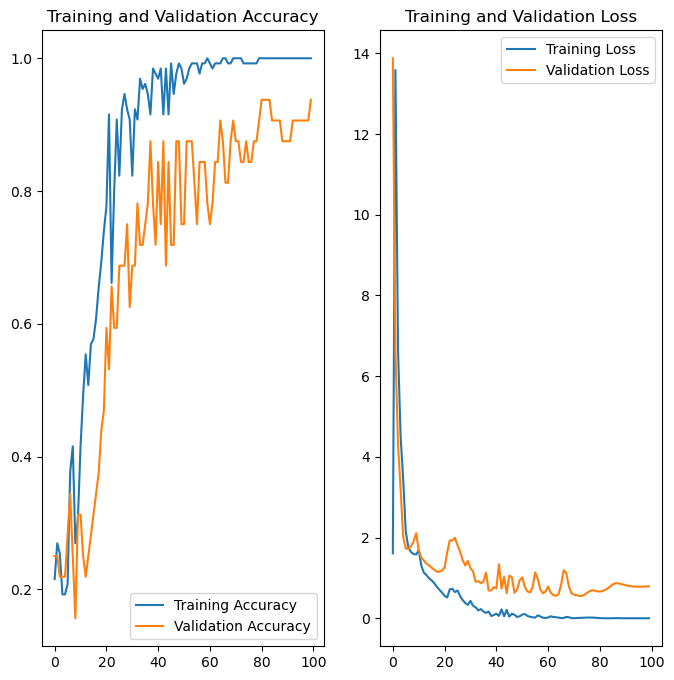

In [43]:
def plot_accuracy_loss(history):
    '''
    plot the accuracy and the loss on the training and test dataset.        
    '''  
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))
    # Plotting training and validation accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
   
    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    

plot_accuracy_loss(history)


The plots show that while the accuracy on the train dataset reaches 100%, on the test dataset it stays around .9. We also see that after the first 30 epochs accuracy of the model doesnot change.

As there are a small number of training examples, there seems to be overfitting. It means that the model will have a difficult time generalizing on a new dataset. Let us explore Data Augmentation and [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to address this problem.

In [44]:
append_dl_model_accuracy_score(basic_model,'Sequential',train_ds,test_ds)

1/1 [==============================] - 0s 21ms/step


Data Augmentation helps improve the model's robustness and ability to handle variations in the input data. The augmented data is generated on-the-fly, which means that each batch during training will receive a slightly different version of the input data due to these random transformations. However in our case we only have 1 batch so the model might not generalize a lot.

In [45]:
data_augmentation = Sequential(
    [
        # Randomly flip the input horizontally and vertically
        layers.RandomFlip("horizontal_and_vertical", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        
        # Randomly rotate the input
        layers.RandomRotation(0.2),
        
        # Randomly zoom into or out of the input
        layers.RandomZoom(0.2),
    ]
)

Let us look at how the data augmentation has modified the images.

2023-12-11 22:53:25.019394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:25.276154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:25.865368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:25.881058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:26.021795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:26.038947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

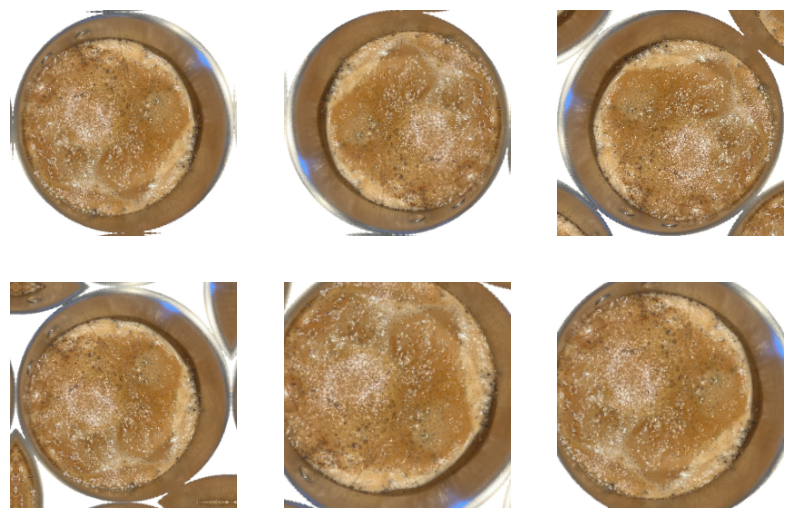

In [46]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

So we see that the images have been altered in varying ways. One caveat though is that there is some image components added outside of the pan area which was not in the original image.

Let us also add a droput layer with a factor of .1 to avoid overfitting.

In [47]:
def get_optimized_model():
    '''
    returns an aoptimized model with preconfigured layers including for data augmentation and dropout.
    '''
    
    return Sequential([
        # Rescale pixel values to the range [0, 1]
        layers.Rescaling(1./255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    
        # Data augmentation pipeline
        data_augmentation,
    
        # First convolutional layer with 16 filters, 3x3 kernel, 'same' padding, and ReLU activation
        layers.Conv2D(16, 3, padding='same', activation='relu'),
    
        # Max pooling layer
        layers.MaxPooling2D(),
    
        # Second convolutional layer with 32 filters, 3x3 kernel, 'same' padding, and ReLU activation
        layers.Conv2D(32, 3, padding='same', activation='relu'),
    
        # Another max pooling layer
        layers.MaxPooling2D(),
    
        # Third convolutional layer with 64 filters, 3x3 kernel, 'same' padding, and ReLU activation
        layers.Conv2D(64, 3, padding='same', activation='relu'),
    
        # Another max pooling layer
        layers.MaxPooling2D(),
    
        # Dropout layer to prevent overfitting
        layers.Dropout(0.1),
    
        # Flatten the output to a 1D array
        layers.Flatten(),
    
        # Fully connected layer with 128 neurons and ReLU activation
        layers.Dense(128, activation='relu'),
    
        # Output layer with 'num_classes' neurons (for classification task)
        layers.Dense(num_classes, name="outputs")
])

Let us fit an optimized model and make it go over 200 iterations. 

2023-12-11 22:53:27.115935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:27.126887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:28.381231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:28.381800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:28.890234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:28.890366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

2023-12-11 22:53:36.889600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:36.889939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:37.313526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:37.314005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:37.601035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:37.601531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

2023-12-11 22:53:45.850442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:45.850918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:46.099629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:46.100057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:46.378360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:46.379021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

2023-12-11 22:53:52.474421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:52.474836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:52.713322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:52.713802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:52.950507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:52.950961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

2023-12-11 22:53:58.679237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:58.679416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:58.921268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:58.921380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:59.158659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:53:59.159006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

2023-12-11 22:54:04.681734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:04.682589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:04.924033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:04.931346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:05.170373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:05.170791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

2023-12-11 22:54:10.736848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:10.737280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:10.979238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:10.979449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:11.223750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:11.223943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

2023-12-11 22:54:16.819177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:16.819467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:17.058124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:17.058331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:17.302091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-11 22:54:17.302438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

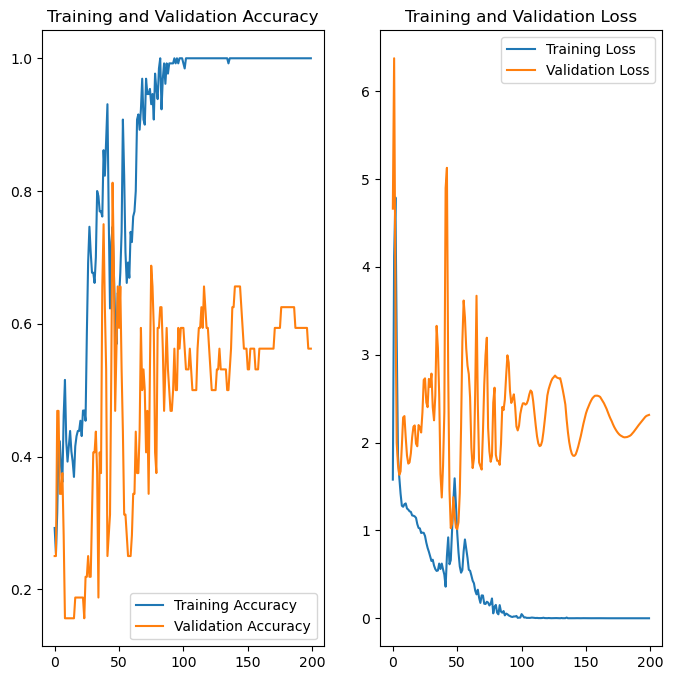

In [48]:
model_opt = get_optimized_model()

model_opt.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=200
history = model_opt.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  verbose=0,
)

plot_accuracy_loss(history)


Print the model summary and add the accuracy of the train/test dataset.

In [49]:
model_opt.summary()
append_dl_model_accuracy_score(model_opt,'Sequential with Rescale, Dropout',train_ds,test_ds)
model_opt.get_metrics_result()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 125, 125, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                 

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.3153553>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5625>}

We also kept some images in a separate folder which were never used as part of train/test set. Let us try to use the last model to make predictions on these images to see the resulting prediction.

In [50]:
unknown_data_path = pathlib.Path(data_path_unknown).with_suffix('')
unknown_ds = tf.keras.utils.image_dataset_from_directory(
  unknown_data_path,
    labels='inferred',
    color_mode='rgb',
  image_size=(IMG_WIDTH,IMG_HEIGHT),
  batch_size=32)

Found 6 files belonging to 5 classes.


1/1 [==============================] - 0s 9ms/step


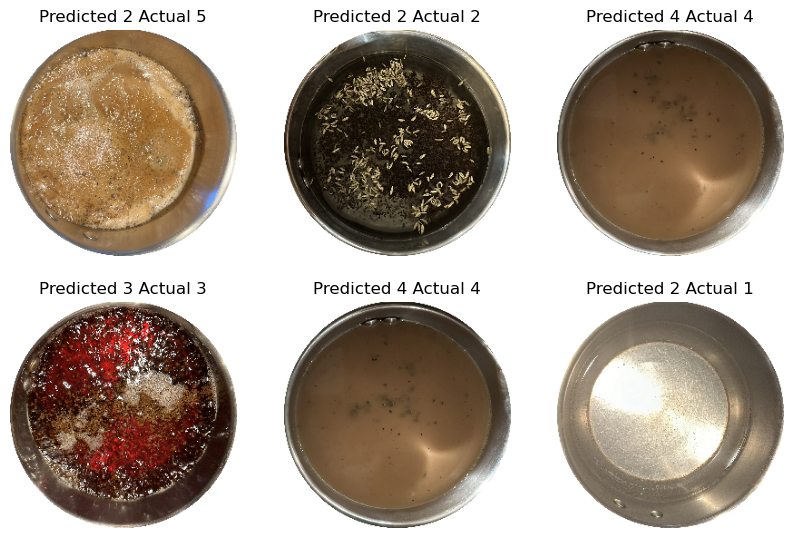

In [51]:
plt.figure(figsize=(10, 10))
for images, labels in unknown_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    img_array = images[i].numpy().astype("uint8")
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_opt.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    title = "Predicted "+ class_names[np.argmax(score)] + " Actual "+ class_names[labels[i]]
    plt.title(title)
    plt.axis("off")

One of the goals set for the project was to deploy the model in an Android app and use it for live predictions. We will use the tensorflow model with rescaling and dropout and deploy it in the app.


In [52]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_opt)
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/cx/mf6gvjzx1tddl1cnr44ngd100000gn/T/tmpetjfvuts/assets


INFO:tensorflow:Assets written to: /var/folders/cx/mf6gvjzx1tddl1cnr44ngd100000gn/T/tmpetjfvuts/assets
2023-12-11 22:54:25.591746: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-11 22:54:25.591756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-11 22:54:25.594070: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/cx/mf6gvjzx1tddl1cnr44ngd100000gn/T/tmpetjfvuts
2023-12-11 22:54:25.595587: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-11 22:54:25.595592: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/cx/mf6gvjzx1tddl1cnr44ngd100000gn/T/tmpetjfvuts
2023-12-11 22:54:25.599770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-11 22:54:25.600662: I tensorflow/cc/saved_model/load

In [53]:
print(export_model_path)
save_path = os.path.join(export_model_path, "")
tf.saved_model.save(model_opt, save_path)

/Users/pulkit/code/final/kraftwerk/capstone_project/model
INFO:tensorflow:Assets written to: /Users/pulkit/code/final/kraftwerk/capstone_project/model/assets


INFO:tensorflow:Assets written to: /Users/pulkit/code/final/kraftwerk/capstone_project/model/assets


Let us look at the accuracy over train and test set across all the models trained as part of the analysis.

In [54]:
results = {'model':model_descs,'train score':accuracy_scores_train,'test score':accuracy_scores_test}
results_df = pd.DataFrame(results)
#results_df = results_df.set_index('model')

results_df.sort_values(by='test score', ascending=False)

,model,train score,test score
5,Sequential,1.000000,0.937500
4,SVC GridSearch(with Hog),1.000000,0.727273
6,"Sequential with Rescale, Dropout",0.700000,0.562500
1,KNeighborsClassifier GridSearch,0.255814,0.242424
2,SVC GridSearch(Gray Scale),0.271318,0.242424
3,SVC with Hog,1.000000,0.242424
0,KNeighborsClassifier,0.178295,0.181818


In [55]:
pd.set_option('display.max_colwidth', None)
best_models = {'model':model_descs,'best estimator':best_estimators,'test score':accuracy_scores_test}
models_df = pd.DataFrame(best_models)
models_df.sort_values(by='test score', ascending=False)

,model,best estimator,test score
5,Sequential,,0.937500
4,SVC GridSearch(with Hog),"(RGB2FeatureTransformer(cells_per_block=(5, 5), pixels_per_cell=(9, 9)), StandardScaler(), SVC())",0.727273
6,"Sequential with Rescale, Dropout",,0.562500
1,KNeighborsClassifier GridSearch,"(StandardScaler(), KNeighborsClassifier(n_neighbors=45))",0.242424
2,SVC GridSearch(Gray Scale),"(StandardScaler(), SVC(kernel='linear'))",0.242424
3,SVC with Hog,,0.242424
0,KNeighborsClassifier,,0.181818


**Next Steps**
- We want to increaese the number of samples across different categories to improve accuracy of the model.
- We have trained a 3 layer model, we want to compare the impact of varying the number of layers on the model accuracy.
- We also want to perform GridSearch using KerasClassifier to find the best model parameters.